In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import load_dataset, load_metric
import numpy as np
from utils import ROUGE_L, ROUGE_N, BLEU, tokenize, correl
import matplotlib.pyplot as plt

c:\Users\ANTOINE\Desktop\GIT\natural-language-processing\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")
max_length = 512
dataset = load_dataset("bible_para", lang1="en", lang2="fr") #translation 

Using custom data configuration en-fr-lang1=en,lang2=fr
Reusing dataset bible_para (C:\Users\ANTOINE\.cache\huggingface\datasets\bible_para\en-fr-lang1=en,lang2=fr\0.0.0\b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1)
100%|██████████| 1/1 [00:00<00:00,  7.77it/s]


In [4]:
# exemple on a sample
fr_sentence = dataset['train'][0]['translation']['fr']    # train is the only split available
en_sentence = dataset['train'][0]['translation']['en']

prefix = 'translate English to French:'
input_ids = tokenizer(prefix + en_sentence, return_tensors="pt", max_length=max_length, truncation=True).input_ids
output = model.generate(input_ids=input_ids)

print('INPUT:', en_sentence)
print('OUTPUT:', tokenizer.decode(output[0], skip_special_tokens=True))
print('GROUND TRUTH:', fr_sentence)

INPUT: In the beginning God created the heavens and the earth.
OUTPUT: Au début, Dieu créa les cieux et la terre.
GROUND TRUTH: Au commencement, Dieu créa les cieux et la terre.


In [8]:
# testing the performances on the validation set with ROUGE, BLEU

def evaluate(n_iter) : 
    'evaluates the T5 model for translation on the '
    scores = {
        'rouge1' : [],
        'rouge2' : [], 
        'rougeL' : [], 
        'bleu' : []
    }

    true_scores = {
        'rouge1' : [],
        'rouge2' : [], 
        'rougeL' : [], 
        'bleu' : []
    }


    BLEU_ = load_metric("bleu")
    ROUGE_ = load_metric("rouge")
    for i, data in enumerate(dataset['train']) : 
        fr_sentence = data['translation']['fr']
        en_sentence = data['translation']['en']
        input_ids = tokenizer(prefix + en_sentence, return_tensors="pt", max_length=max_length, truncation=True).input_ids
        output = model.generate(input_ids=input_ids)
        output = tokenizer.decode(output[0], skip_special_tokens=True)

        #print(f'{i}/10 :\n OUTPUT : {output}\n TRUTH: {fr_sentence}')

        output_tokens = tokenize(output)
        true_tokens = tokenize(fr_sentence)
        scores['rouge1'].append(ROUGE_N(output_tokens, true_tokens, n=1))
        scores['rouge2'].append(ROUGE_N(output_tokens, true_tokens, n=2))
        scores['rougeL'].append(ROUGE_L(output_tokens, true_tokens))
        scores['bleu'].append(BLEU(output_tokens, true_tokens, n_max = 4))


        ROUGE_.add_batch(predictions=[output_tokens], references=[[true_tokens]])
        BLEU_.add_batch(predictions=[output_tokens], references=[[true_tokens]])

        rouge_ = ROUGE_.compute(use_agregator = False)
        bleu_= BLEU_.compute()

        true_scores['rouge1'].append(rouge_['rouge1'][0])
        true_scores['rouge2'].append(rouge_['rouge2'][0])
        true_scores['rougeL'].append(rouge_['rougeL'][0])
        true_scores['bleu'].append(bleu_['bleu'])

        if i > n_iter - 2 : 
            break

    for dic in [scores, true_scores] : 
        for key in ['rouge1', 'rouge2', 'rougeL', 'bleu'] : 
            dic[key] = np.array(dic[key])


    return scores, true_scores

In [9]:
scores, true_scores = evaluate(n_iter = 15)

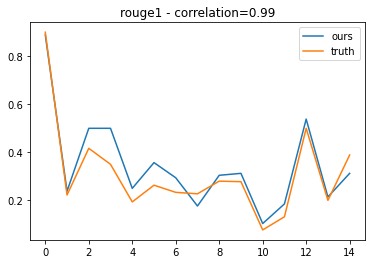

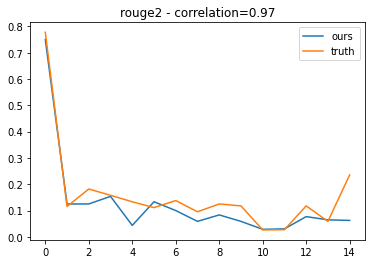

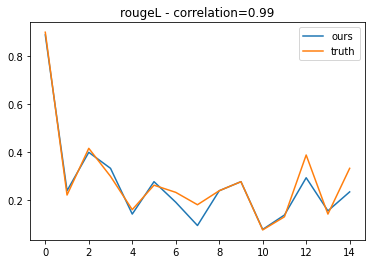

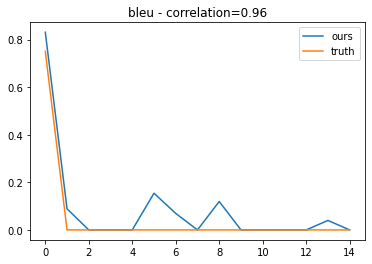

In [10]:
def correl(A, B) : 
    return A/np.linalg.norm(A)  @ B/np.linalg.norm(B)

def plotting(key, sc, tsc) : 
    plt.title(f'{key} - correlation={correl(sc, tsc):.2f}')
    plt.plot(sc, label = 'ours')
    plt.plot(tsc, label = 'truth')
    plt.legend()
    plt.show()


for key in ['rouge1', 'rouge2'] : 
    sc = scores[key][:, 1]
    tsc = true_scores[key][:, 1]
    plotting(key, sc, tsc)

key = 'rougeL'
sc = scores[key]
tsc = true_scores[key][:, 1]
plotting(key, sc, tsc)


key = 'bleu'
sc = scores[key]
tsc = true_scores[key]
plotting(key, sc, tsc)

We can see that the metics that we implemented are very close to the true ones as all the correlations are greater than 0.96

In [25]:
scores, true_scores = evaluate(n_iter = 1000)

In [27]:
for key in ['rouge1', 'rouge2'] : 
    sc = scores[key].mean(axis = 0) # taking the score average over the 1000 samples
    sc[2] = sc[0] * sc[1] / (sc[0] + sc[1])#computing f1 score

    print(key.upper())
    print(f'OURS :\n\tprecision: {sc[0]:.2f}\n\trecall: {sc[1]:.2f}\n\tf1: {sc[2]:.2f}')
    print(f'TRUTH:\n\tprecision: {sc[0]:.2f}\n\trecall: {sc[1]:.2f}\n\tf1: {sc[2]:.2f}')
    print('==================')

key = 'rougeL'
sc = scores[key].mean() # taking the score average over the 1000 samples
print('ROUGE-L')
print(f'OURS : {sc:.2f}')
print(f'TRUTH: {sc:.2f}')
print('==================')


key = 'bleu'
sc = scores[key].mean() # taking the score average over the 1000 samples
print(key.upper())
print(f'OURS : {sc:.2f}')
print(f'TRUTH: {sc:.2f}')
print('==================')

ROUGE1
OURS :
	precision: 0.42
	recall: 0.23
	f1: 0.15
TRUTH:
	precision: 0.42
	recall: 0.23
	f1: 0.15
ROUGE2
OURS :
	precision: 0.17
	recall: 0.09
	f1: 0.06
TRUTH:
	precision: 0.17
	recall: 0.09
	f1: 0.06
ROUGE-L
OURS : 0.19
TRUTH: 0.19
BLEU
OURS : 0.06
TRUTH: 0.06
